Imports

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pyarrow.parquet as pq
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pyarrow.parquet as pq
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os


In [ ]:
# mount
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Device setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pyarrow.parquet as pq

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


Loading our queries dataset

In [ ]:
DATA_PATH_MERGED = "/content/drive/MyDrive/BT4222 Group 3/1. Data Preparation/Data/clusters/user_behavior_with_clusters_k4_pc3.parquet"

queries_table_full = pq.read_table(DATA_PATH_MERGED)
queries_df = pd.DataFrame(queries_table_full.to_pydict())

print(f"Total users: {len(queries_df)}") # just a sanity check!


Total users: 173831


We'll create an arbritary `user_id` since we know that each row in the dataset corresponds to a unique user, and no user id has been provided

In [ ]:
queries_df = queries_df.reset_index().rename(columns={'index': 'user_id'})


A sanity check again that we do not have any `NaN` values in a user's candidate label list (we've checked this in the EDA stage, but we check again since things might have gone wrong in the previous changes)

In [ ]:
# check for NaNs in the original candidate_label_list_int column
nan_counts = queries_df['candidate_label_list_int'].apply(lambda x: any(pd.isna(x)))
print(f"Number of users with any NaN in candidate_label_list_int: {nan_counts.sum()}")

# also see which user_ids have NaN
print("Example user_ids with NaN labels:", queries_df.loc[nan_counts, :].index.tolist())


Number of users with any NaN in candidate_label_list_int: 0
Example user_ids with NaN labels: []


Thankfully everything seems fine!

**Declaring Meta features**

We select a list of meta features from our feature engineering stage. These features capture additional context about user behavior, item diversity, and temporal patterns, which are used alongside sequence and candidate embeddings in the model.

In [ ]:
meta_cols = ['nunique_cats_1', 'nunique_cats_2', 'nunique_cats_3', 'nunique_cats_4',
             'history_len', 'avg_log_cat_1_popularity', 'click_ratio', 'cart_ratio',
             'order_ratio', 'cluster', 'avg_interaction_time_gap',
             'std_time_gap', 'max_gap', 'total_time_decay', 'avg_time_decay']

# extract the meta features from the main dataframe
meta_df = queries_df[meta_cols].fillna(0)

# scale the features to 0 mean and unit variance
scaler = StandardScaler()
scaled_meta_features = scaler.fit_transform(meta_df)

# convert the scaled features into a PyTorch tensor
meta_features_tensor = torch.tensor(scaled_meta_features, dtype=torch.float32)

print(f"Meta features shape: {meta_features_tensor.shape}")


Meta features shape: torch.Size([173831, 15])


We now have `meta_features_tensor`, a [num_samples, num_meta_features] tensor.

This is to be fed into the model alongside the sequence and candidate embeddings.

**Flatten Candidate-User Pairs (exploded data)**

First we must check for those with empty lists first and filter them out, since they have no candidates (our preprocessing and sampling stage had led to 2k out of 173k users having empty candidate lists).



In [ ]:
# check for users with empty candidate lists
empty_candidate_wid = queries_df[queries_df['candidate_wid_list'].apply(lambda x: len(x) == 0)]
empty_label_list = queries_df[queries_df['candidate_label_list_int'].apply(lambda x: len(x) == 0)]

print(f"Number of users with empty candidate_wid_list: {len(empty_candidate_wid)}")
print(f"Number of users with empty candidate_label_list_int: {len(empty_label_list)}")

# example user_ids
print("Example user_ids with empty candidate_wid_list:", empty_candidate_wid.index.tolist()[:10])
print("Example user_ids with empty candidate_label_list_int:", empty_label_list.index.tolist()[:10])


Number of users with empty candidate_wid_list: 0
Number of users with empty candidate_label_list_int: 2103
Example user_ids with empty candidate_wid_list: []
Example user_ids with empty candidate_label_list_int: [110, 142, 155, 242, 289, 345, 610, 617, 656, 681]


We confirm that there are 2103 users with empty candidate lsits, and we'll now filter them out, before exploding the candidate lists such that each row in `users_and_candidates_df_flat` corresponds to a user–candidate pair.



In [ ]:
# filter out users with empty candidate lists
queries_df_filtered = queries_df[
    (queries_df['candidate_wid_list'].apply(len) > 0) &
    (queries_df['candidate_label_list_int'].apply(len) > 0)
].copy()

print(f"Original number of users: {len(queries_df)}")
print(f"Number of users after filtering empty candidate lists: {len(queries_df_filtered)}")

# now create the users_and_candidates_df
users_and_candidates_df = queries_df_filtered[['candidate_wid_list', 'candidate_label_list_int']].copy()
users_and_candidates_df = users_and_candidates_df.reset_index().rename(columns={'index': 'user_id'})

# explode the candidate lists
users_and_candidates_df_flat = users_and_candidates_df.explode(
    ['candidate_wid_list', 'candidate_label_list_int']
).rename(columns={'candidate_wid_list': 'candidate_wid', 'candidate_label_list_int': 'label'}).reset_index(drop=True)

# quick check
print(f"Flattened data shape: {users_and_candidates_df_flat.shape}")
print(f"First 5 rows:\n{users_and_candidates_df_flat.head()}")
print(f"Label distribution:\n{users_and_candidates_df_flat['label'].value_counts()}")


Original number of users: 173831
Number of users after filtering empty candidate lists: 171728
Flattened data shape: (1594553, 3)
First 5 rows:
   user_id candidate_wid label
0        0      36098226     1
1        0      82122191     0
2        0      34768767     0
3        0      71429327     0
4        0      87635543     0
Label distribution:
label
0    1273657
1     224487
2      75573
3      20836
Name: count, dtype: int64


Before evaluation or batching, we group all candidate items for each user into lists.  

This ensures that each user’s candidates and labels are stored together, which is useful for:

- Efficient batching in the DataLoader  
- Ranking and recommendation evaluation per user

In [ ]:
# group by user_id to combine all candidates into lists
user_groups = users_and_candidates_df_flat.groupby('user_id').agg({
    'candidate_wid': list,
    'label': list
}).reset_index()

print(f"Total grouped users: {len(user_groups)}")
print(user_groups.head())


Total grouped users: 171728
   user_id                                      candidate_wid  \
0        0  [36098226, 82122191, 34768767, 71429327, 87635...   
1        1  [30857980, 44577431, 82696473, 94722703, 51139...   
2        2  [42155506, 90092899, 66647496, 92302381, 61552...   
3        3  [97234676, 83859812, 90043344, 51562568, 19973...   
4        4  [19711065, 83045333, 65555812, 23738187, 84489...   

                            label  
0                 [1, 0, 0, 0, 0]  
1  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
2  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
3                 [1, 0, 0, 0, 0]  
4  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]  


To verify the grouping, we select a specific user
and inspect the following as sanity check:

- `candidate_wid`: List of candidate item IDs for this user  
- `label`: Corresponding interaction labels (0–3, where 3 indicates highest engagement)


In [ ]:
user_id_to_check = 0
row = user_groups[user_groups['user_id'] == user_id_to_check].iloc[0]
print(f"User {user_id_to_check} candidate IDs: {row['candidate_wid']}")
print(f"User {user_id_to_check} labels: {row['label']}")


User 0 candidate IDs: ['36098226', '82122191', '34768767', '71429327', '87635543']
User 0 labels: [1, 0, 0, 0, 0]


Building vocabularies for items, interaction types, time binds

- **History items**: Every user has a `history_wid_list` — all the items they interacted with in the past.  
  We flatten all these lists to get the set of unique item IDs in histories. These are what we currently embed for the LSTM + attention user encoder.

- **Interaction types**: Ordinal types (e.g., click, add to cart, purchase) are also converted to integer indices for embedding.

- **Time bins**: Interaction timestamps are log-scaled to handle skew, then discretized into bins for embedding.






In [ ]:
# combine all item IDs that appear in the users' interaction histories.
# each user's 'history_wid_list' is a list of item IDs, so we flatten all these lists.
all_wids = set([wid for sublist in queries_df['history_wid_list'] for wid in sublist])
wid2idx = {wid: i+1 for i, wid in enumerate(all_wids)}  # 0 reserved for padding

# interaction types
all_types = set([t for sublist in queries_df['history_type_list_ordinal'] for t in sublist])
type2idx = {t: i+1 for i, t in enumerate(all_types)}  # 0 = padding

# time bins
all_times = [t for sublist in queries_df['history_time_list'] for t in sublist]
log_times = np.log1p(all_times)
num_bins = 10
bins = np.expm1(np.linspace(log_times.min(), log_times.max(), num_bins))
bins = np.round(bins).astype(int)

print(f"Vocab sizes - Items: {len(wid2idx)}, Types: {len(type2idx)}, Time bins: {len(bins)}")


Vocab sizes - Items: 474040, Types: 4, Time bins: 10


At this point, we have:
1. wid2idx → mapping all items (history + candidates) to indices for embedding.
2. type2idx → mapping interaction types.
3. bins → discretized time bins for time embeddings.


Candidate encodings artifacts

In [ ]:
candidate_encodings = torch.load("/content/drive/MyDrive/BT4222 Group 3/2. Models/Encoders/candidate_encoder_ckpt.pt")
print("✅ Loaded candidate encoder artifacts")


✅ Loaded candidate encoder artifacts


**NCFDatasetGrouped class**

Now we design a custom PyTorch Dataset, `NDCFDatasetGrouped` , to **group all candidates per user into a single sample** for efficient batching.  


**Input:**  
  - `users_and_candidates_df`: Flattened user-candidate pairs with labels  
  - `queries_df`: Original user query/history data  
  - `meta_features_tensor`: Scaled meta features per user  
  - `wid2idx`, `type2idx`, `bins`: Encoding vocabularies for items, types, and time  

**Functionality:**  
  - Groups candidates and labels per user (`groupby('user_id')`)  
  - Retrieves and encodes user history sequences (`wid_seq`, `type_seq`, `time_seq`) up to `max_len`  
  - Encodes all candidate items for the user  
  - Returns a dictionary containing:  
    - `user_id`  
    - Padded sequences: `wid_seq`, `type_seq`, `time_seq`  
    - Candidate indices: `candidate_wid_idxs`  
    - Meta features: `meta_features`  
    - Candidate labels: `labels`  

**Output:**  
  Each sample contains all information needed for **ranking the candidates** for that user during model training or evaluation.  

This setup allows the DataLoader to efficiently handle users with varying numbers of candidates and history lengths.


In [ ]:
class NCFDatasetGrouped(Dataset):
    """Group all candidates per user into single samples for efficient batching"""
    def __init__(self, users_and_candidates_df, queries_df, meta_features_tensor,
                 wid2idx, type2idx, bins, max_len=200):
        """
        Args:
            users_and_candidates_df: Flattened user-candidate pairs with labels
            queries_df: Original queries_df with history columns
            meta_features_tensor: Scaled meta features [num_users, num_meta_features]
            wid2idx, type2idx, bins: Vocabularies for encoding
            max_len: Max sequence length for history
        """
        self.queries_df = queries_df
        self.meta_features_tensor = meta_features_tensor
        self.wid2idx = wid2idx
        self.type2idx = type2idx
        self.bins = bins
        self.max_len = max_len

        # group by user_id to batch all candidates together
        self.user_groups = users_and_candidates_df.groupby('user_id').agg({
            'candidate_wid': list,
            'label': list
        }).reset_index()

        print(f"Grouped dataset: {len(self.user_groups)} users with avg {users_and_candidates_df.groupby('user_id').size().mean():.1f} candidates/user")

    def __len__(self):
        return len(self.user_groups)

    def __getitem__(self, idx):
        row = self.user_groups.iloc[idx]
        user_id = row['user_id']
        candidate_wids = row['candidate_wid']
        labels = row['label']
        labels = [int(l) for l in labels]

        # get user history (encoded ONCE per user!)
        user_row = self.queries_df.loc[self.queries_df['user_id'] == user_id].iloc[0]
        wid_seq = user_row['history_wid_list'][-self.max_len:]
        type_seq = user_row['history_type_list_ordinal'][-self.max_len:]
        time_seq = user_row['history_time_list'][-self.max_len:]

        # encode sequences
        wid_seq = [self.wid2idx.get(w, 0) for w in wid_seq]
        type_seq = [self.type2idx.get(t, 0) for t in type_seq]
        time_seq = [np.digitize(t, self.bins) for t in time_seq]

        # encode all candidates for this user
        candidate_wid_idxs = [self.wid2idx.get(w, 0) for w in candidate_wids]

        return {
            'user_id': user_id,
            'wid_seq': torch.tensor(wid_seq, dtype=torch.long),
            'type_seq': torch.tensor(type_seq, dtype=torch.long),
            'time_seq': torch.tensor(time_seq, dtype=torch.long),
            'candidate_wid_idxs': torch.tensor(candidate_wid_idxs, dtype=torch.long),
            'meta_features': self.meta_features_tensor[user_id],
            'labels': torch.tensor(labels, dtype=torch.long)
        }


**Collate Function for grouped batching**

When batching users for training, each user may have a different number of history interactions and candidate items. We define a custom collate function to handle padding and organize data into tensors suitable for model input.

In [ ]:
def collate_fn_grouped(batch):
    """Collate function for grouped batching with padding"""
    # pad user history sequences
    wid_seqs = pad_sequence([b['wid_seq'] for b in batch], batch_first=True, padding_value=0)
    type_seqs = pad_sequence([b['type_seq'] for b in batch], batch_first=True, padding_value=0)
    time_seqs = pad_sequence([b['time_seq'] for b in batch], batch_first=True, padding_value=0)
    lengths = torch.tensor([len(b['wid_seq']) for b in batch], dtype=torch.long)

    # pad candidate lists (users have different numbers of candidates)
    max_candidates = max(len(b['candidate_wid_idxs']) for b in batch)
    candidate_wid_idxs = torch.zeros((len(batch), max_candidates), dtype=torch.long)
    labels = torch.full((len(batch), max_candidates), -1, dtype=torch.long)  # -1 = ignore in loss

    for i, b in enumerate(batch):
        n_cands = len(b['candidate_wid_idxs'])
        candidate_wid_idxs[i, :n_cands] = b['candidate_wid_idxs']
        labels[i, :n_cands] = b['labels']

    # stack meta features and user IDs
    meta_features = torch.stack([b['meta_features'] for b in batch])
    user_ids = torch.tensor([b['user_id'] for b in batch], dtype=torch.long)

    return {
        'user_id': user_ids,
        'wid_seq': wid_seqs,
        'type_seq': type_seqs,
        'time_seq': time_seqs,
        'lengths': lengths,
        'candidate_wid_idxs': candidate_wid_idxs,
        'meta_features': meta_features,
        'labels': labels
    }


**Train-Test-Val split**

To prevent user-level data leakage, we split the dataset by unique users rather than individual interactions. This ensures that a single user's interactions do not appear in multiple splits.

We adopt a 70-15-15 split.

In [ ]:
from sklearn.model_selection import train_test_split

unique_users = users_and_candidates_df_flat['user_id'].unique()
train_users, temp_users = train_test_split(unique_users, test_size=0.3, random_state=42)
val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=42)

train_df = users_and_candidates_df_flat[users_and_candidates_df_flat['user_id'].isin(train_users)]
val_df = users_and_candidates_df_flat[users_and_candidates_df_flat['user_id'].isin(val_users)]
test_df = users_and_candidates_df_flat[users_and_candidates_df_flat['user_id'].isin(test_users)]

print(f"\nData splits:")
print(f"  Train: {len(train_df):,} interactions from {len(train_users):,} users")
print(f"  Val: {len(val_df):,} interactions from {len(val_users):,} users")
print(f"  Test: {len(test_df):,} interactions from {len(test_users):,} users")



Data splits:
  Train: 1,118,198 interactions from 120,209 users
  Val: 238,785 interactions from 25,759 users
  Test: 237,570 interactions from 25,760 users


In [ ]:
# sanity check again
# train_user_groups = train_df.groupby('user_id').agg({
#     'candidate_wid': list,
#     'label': list
# }).reset_index()

# # check first few rows
# print(train_user_groups.head())

# # check lengths of candidates and labels
# train_user_groups['n_candidates'] = train_user_groups['candidate_wid'].apply(len)
# train_user_groups['n_labels'] = train_user_groups['label'].apply(len)
# print(train_user_groups[['user_id','n_candidates','n_labels']].head())

# make sure each user has same number of candidates and labels
# assert all(train_user_groups['n_candidates'] == train_user_groups['n_labels']), "Mismatch!"


creating the datasets

In [ ]:
train_dataset = NCFDatasetGrouped(train_df, queries_df, meta_features_tensor, wid2idx, type2idx, bins)
val_dataset = NCFDatasetGrouped(val_df, queries_df, meta_features_tensor, wid2idx, type2idx, bins)
test_dataset = NCFDatasetGrouped(test_df, queries_df, meta_features_tensor, wid2idx, type2idx, bins)


Grouped dataset: 120209 users with avg 9.3 candidates/user
Grouped dataset: 25759 users with avg 9.3 candidates/user
Grouped dataset: 25760 users with avg 9.2 candidates/user


create dataloaders

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32  # smaller because each sample has multiple candidates

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn_grouped, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        collate_fn=collate_fn_grouped, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         collate_fn=collate_fn_grouped, num_workers=2, pin_memory=True)

print(f"\nDataloader info:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")



Dataloader info:
  Train batches: 3757
  Val batches: 805
  Test batches: 805


**Attention module (for LSTM)**

(copy-pasted from stage 1)

We implement a simple attention mechanism over the LSTM outputs to allow the model to focus on the most relevant parts of a user's interaction history. This helps the model weigh certain historical interactions more heavily when forming the user representation.

In [ ]:
class Attention(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        # linear layer to compute attention scores for each timestep
        self.attn = nn.Linear(emb_dim, 1)

    def forward(self, x, mask):
        # x: [batch, seq_len, emb_dim]
        scores = self.attn(x).squeeze(-1)  # [batch, seq_len]
        scores = scores.masked_fill(mask == 0, float('-inf'))  # ignore padded positions
        weights = torch.softmax(scores, dim=1).unsqueeze(-1)  # [batch, seq_len, 1]
        out = (x * weights).sum(dim=1)  # weighted sum
        return out



- `mask` ensures padded timesteps are ignored when computing attention.

- The output is a weighted sum of the LSTM hidden states, producing a fixed-size representation of the user history.

**Candidate encoder**

(copy-pasted from stage 2)

In [ ]:
class CandidateEncoder(nn.Module):
    def __init__(self, num_wid, num_brand, num_shop, num_c1, num_c2, num_c3, num_c4,
                 brand_lookup, shop_lookup, c1_lookup, c2_lookup, c3_lookup, c4_lookup,
                 emb_dim=64):
        super().__init__()
        self.emb_dim = emb_dim

        self.wid_emb = nn.Embedding(num_wid, emb_dim, padding_idx=0)
        self.brand_emb = nn.Embedding(num_brand, emb_dim, padding_idx=0)
        self.shop_emb = nn.Embedding(num_shop, emb_dim, padding_idx=0)
        self.c1_emb = nn.Embedding(num_c1, emb_dim, padding_idx=0)
        self.c2_emb = nn.Embedding(num_c2, emb_dim, padding_idx=0)
        self.c3_emb = nn.Embedding(num_c3, emb_dim, padding_idx=0)
        self.c4_emb = nn.Embedding(num_c4, emb_dim, padding_idx=0)

        self.register_buffer("brand_lookup", brand_lookup)
        self.register_buffer("shop_lookup", shop_lookup)
        self.register_buffer("c1_lookup", c1_lookup)
        self.register_buffer("c2_lookup", c2_lookup)
        self.register_buffer("c3_lookup", c3_lookup)
        self.register_buffer("c4_lookup", c4_lookup)

    def forward(self, candidate_wid_idx):
        # candidate_wid_idx: [batch, num_candidates]
        wid_idx = candidate_wid_idx

        # Lookup attributes
        brand_idx = self.brand_lookup[wid_idx]
        shop_idx = self.shop_lookup[wid_idx]
        c1_idx = self.c1_lookup[wid_idx]
        c2_idx = self.c2_lookup[wid_idx]
        c3_idx = self.c3_lookup[wid_idx]
        c4_idx = self.c4_lookup[wid_idx]

        # Embed everything
        wid_e = self.wid_emb(wid_idx)
        brand_e = self.brand_emb(brand_idx)
        shop_e = self.shop_emb(shop_idx)
        c1_e = self.c1_emb(c1_idx)
        c2_e = self.c2_emb(c2_idx)
        c3_e = self.c3_emb(c3_idx)
        c4_e = self.c4_emb(c4_idx)

        # Sum embeddings
        cand_emb = wid_e + brand_e + shop_e + c1_e + c2_e + c3_e + c4_e
        return cand_emb  # [batch, num_candidates, emb_dim]


## Approach 1: Standard classification with CrossEntropyLoss

### SequentialHybridNCF Model

We define the model here!

This fuses:
1. User history embeddings (LSTM + Attention)
2. Candidate embeddings (CandidateEncoder)
3. Meta features embeddings (linear projection)

Key components:
1. **User History Encoder (LSTM + Attention)**

- Encodes the user's interaction history with items, types, and time bins.
- LSTM captures sequential dependencies.
- Attention mechanism weights the most relevant interactions for user representation.
- Supports variable-length histories and handles empty histories using a learnable empty_user_emb.

2. **Candidate Encoder (CandidateEncoder)**
- Embeds candidate items with features such as item ID, brand, shop, and category levels.
- Produces dense embeddings for each candidate.

3. **Meta Feature Projection**
- Projects scaled meta features (numerical descriptors) through a linear layer to match embedding dimension.

4. **Fusion & MLP Classification**
- Concatenates: [user_dynamic_emb, candidate_emb, meta_emb].
- Passes through a multi-layer perceptron (MLP) with batch normalization, dropout, and ReLU activations.
- Outputs logits for the ordinal interaction levels







In [ ]:
class SequentialHybridNCF(nn.Module):
    def __init__(self, num_items, num_types, num_time_bins,
                 num_wid, num_brand, num_shop, num_c1, num_c2, num_c3, num_c4,
                 brand_lookup, shop_lookup, c1_lookup, c2_lookup, c3_lookup, c4_lookup,
                 num_meta_features, emb_dim=64, hidden_dim=128, num_classes=4):
        super().__init__()

        # LSTM Encoder for user history
        self.item_emb = nn.Embedding(num_items+1, emb_dim, padding_idx=0)
        self.type_emb = nn.Embedding(num_types+1, emb_dim, padding_idx=0)
        self.time_emb = nn.Embedding(num_time_bins+1, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=emb_dim,
                    batch_first=True, dropout=0.3, num_layers=2)
        self.attention = Attention(emb_dim)
        self.empty_user_emb = nn.Parameter(torch.zeros(1, emb_dim))

        # Candidate encoder
        self.candidate_encoder = CandidateEncoder(
            num_wid, num_brand, num_shop, num_c1, num_c2, num_c3, num_c4,
            brand_lookup, shop_lookup, c1_lookup, c2_lookup, c3_lookup, c4_lookup,
            emb_dim
        )

        # Meta feature projection
        self.meta_linear = nn.Linear(num_meta_features, emb_dim)

        # MLP classifier
        fusion_dim = emb_dim * 3
        self.mlp = nn.Sequential(
            nn.Linear(fusion_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def encode_user_history(self, wid_seq, type_seq, time_seq, lengths):
        """Encode user history with LSTM + Attention"""
        mask = (wid_seq != 0)
        x = self.item_emb(wid_seq) + self.type_emb(type_seq) + self.time_emb(time_seq)

        batch_emb = self.empty_user_emb.repeat(x.size(0), 1)

        non_empty_mask = lengths > 0
        if non_empty_mask.any():
            x_non_empty = x[non_empty_mask]
            lengths_non_empty = lengths[non_empty_mask]
            mask_non_empty = mask[non_empty_mask]

            packed = pack_padded_sequence(x_non_empty, lengths_non_empty.cpu(),
                                          batch_first=True, enforce_sorted=False)
            packed_out, _ = self.lstm(packed)
            out, _ = pad_packed_sequence(packed_out, batch_first=True)

            user_emb_non_empty = self.attention(out, mask_non_empty)
            batch_emb[non_empty_mask] = user_emb_non_empty

        return batch_emb

    def forward(self, wid_seq, type_seq, time_seq, lengths,
                candidate_wid_idxs, meta_features):
        batch_size, num_candidates = candidate_wid_idxs.shape

        # encode user history
        user_dynamic_emb = self.encode_user_history(wid_seq, type_seq, time_seq, lengths)

        # encode candidates
        candidate_emb = self.candidate_encoder(candidate_wid_idxs)

        # meta features
        meta_emb = self.meta_linear(meta_features)

        # expand to match candidates
        user_dynamic_emb_expanded = user_dynamic_emb.unsqueeze(1).expand(-1, num_candidates, -1)
        meta_emb_expanded = meta_emb.unsqueeze(1).expand(-1, num_candidates, -1)

        # fusion
        fusion = torch.cat([user_dynamic_emb_expanded, candidate_emb, meta_emb_expanded], dim=-1)

        # MLP classification
        fusion_flat = fusion.reshape(-1, fusion.size(-1))
        logits_flat = self.mlp(fusion_flat)
        logits = logits_flat.reshape(batch_size, num_candidates, -1)

        return logits


**Model initialisation**

In [ ]:
model = SequentialHybridNCF(
    num_items=len(wid2idx),
    num_types=len(type2idx),
    num_time_bins=len(bins),
    num_wid=candidate_encodings["num_wid"],
    num_brand=candidate_encodings["num_brand"],
    num_shop=candidate_encodings["num_shop"],
    num_c1=candidate_encodings["num_c1"],
    num_c2=candidate_encodings["num_c2"],
    num_c3=candidate_encodings["num_c3"],
    num_c4=candidate_encodings["num_c4"],
    brand_lookup=candidate_encodings["brand_lookup"],
    shop_lookup=candidate_encodings["shop_lookup"],
    c1_lookup=candidate_encodings["c1_lookup"],
    c2_lookup=candidate_encodings["c2_lookup"],
    c3_lookup=candidate_encodings["c3_lookup"],
    c4_lookup=candidate_encodings["c4_lookup"],
    num_meta_features=len(meta_cols),
    emb_dim=64,
    hidden_dim=128,
    num_classes=4
).to(device)


**Load pretrained candidate encoder weights**

In [ ]:
model.candidate_encoder.load_state_dict(candidate_encodings["state_dict"])
print("✅ Candidate encoder weights loaded")


✅ Candidate encoder weights loaded


**Training setup**


In [ ]:

non_weighted_criterion = nn.CrossEntropyLoss(ignore_index=-1)  # -1 still masks padded candidates
# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Reduce LR on plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)


helper function to train epoch

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()  # set model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(loader, desc="Training"):
        # move batch data to device
        wid_seq = batch['wid_seq'].to(device)
        type_seq = batch['type_seq'].to(device)
        time_seq = batch['time_seq'].to(device)
        lengths = batch['lengths'].to(device)
        candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
        meta_features = batch['meta_features'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        logits = model(
            wid_seq, type_seq, time_seq, lengths,
            candidate_wid_idxs, meta_features
        )
        # logits shape: [batch_size, num_candidates, num_classes]

        # mask out padded candidates (labels = -1)
        mask = labels != -1
        logits_flat = logits[mask]  # only valid candidates
        labels_flat = labels[mask]

        # compute loss
        loss = criterion(logits_flat, labels_flat)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

        # predictions for metrics
        preds = torch.argmax(logits_flat, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_flat.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy


validation fn

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            wid_seq = batch['wid_seq'].to(device)
            type_seq = batch['type_seq'].to(device)
            time_seq = batch['time_seq'].to(device)
            lengths = batch['lengths'].to(device)
            candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
            meta_features = batch['meta_features'].to(device)
            labels = batch['labels'].to(device)

            logits = model(wid_seq, type_seq, time_seq, lengths,
                           candidate_wid_idxs, meta_features)

            # mask padding candidates (label = -1)
            mask = labels != -1
            logits_flat = logits[mask]   # [num_valid, num_classes]
            labels_flat = labels[mask]   # [num_valid]

            loss = criterion(logits_flat, labels_flat)
            total_loss += loss.item()

            preds = torch.argmax(logits_flat, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_flat.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1


Training loop

In [ ]:
# TRAINING LOOP

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

num_epochs = 10
best_val_loss = float('inf')
model_path = '/content/drive/MyDrive/BT4222 Group 3/2. Models/lstm_ncf/best_lstm_ncf.pt'
# make in case it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

for epoch in range(num_epochs):
    print("\n" + "="*50)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("="*50)


    # TRAIN
    model.train()
    total_train_loss = 0
    all_train_preds = []
    all_train_labels = []

    for batch in tqdm(train_loader, desc="Training"):
        # move batch to device
        wid_seq = batch['wid_seq'].to(device)
        type_seq = batch['type_seq'].to(device)
        time_seq = batch['time_seq'].to(device)
        lengths = batch['lengths'].to(device)
        candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
        meta_features = batch['meta_features'].to(device)
        labels = batch['labels'].to(device)

        # forward
        logits = model(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)

        # mask padding candidates
        mask = labels != -1
        logits_flat = logits[mask]
        labels_flat = labels[mask]

        # compute loss
        loss = non_weighted_criterion(logits_flat, labels_flat)

        # backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()

        # predictions
        preds = torch.argmax(logits_flat, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels_flat.cpu().numpy())

    train_loss = total_train_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # VALIDATE
    model.eval()
    total_val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            wid_seq = batch['wid_seq'].to(device)
            type_seq = batch['type_seq'].to(device)
            time_seq = batch['time_seq'].to(device)
            lengths = batch['lengths'].to(device)
            candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
            meta_features = batch['meta_features'].to(device)
            labels = batch['labels'].to(device)

            logits = model(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)

            mask = labels != -1
            logits_flat = logits[mask]
            labels_flat = labels[mask]

            loss = non_weighted_criterion(logits_flat, labels_flat)
            total_val_loss += loss.item()

            preds = torch.argmax(logits_flat, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels_flat.cpu().numpy())

    val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='macro', zero_division=0)

    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")

    # SCHEDULER
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning rate: {current_lr:.6f}")

    # SAVE BEST MODEL
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }, model_path)
        print("✅ Saved best model")

print("\n🎉 Training complete!")



Epoch 1/10


Training: 100%|██████████| 3757/3757 [02:19<00:00, 26.96it/s]


Train Loss: 0.6530, Train Acc: 0.7891


Validating: 100%|██████████| 805/805 [00:19<00:00, 42.04it/s]


Val Loss: 0.6184, Val Acc: 0.7988
Val Precision: 0.2711, Recall: 0.2500, F1: 0.2221
Learning rate: 0.001000
✅ Saved best model

Epoch 2/10


Training: 100%|██████████| 3757/3757 [02:20<00:00, 26.72it/s]


Train Loss: 0.6188, Train Acc: 0.7992


Validating: 100%|██████████| 805/805 [00:19<00:00, 41.68it/s]


Val Loss: 0.6142, Val Acc: 0.7997
Val Precision: 0.4553, Recall: 0.2545, F1: 0.2312
Learning rate: 0.001000
✅ Saved best model

Epoch 3/10


Training: 100%|██████████| 3757/3757 [02:26<00:00, 25.61it/s]


Train Loss: 0.6144, Train Acc: 0.8000


Validating: 100%|██████████| 805/805 [00:19<00:00, 42.10it/s]


Val Loss: 0.6112, Val Acc: 0.8005
Val Precision: 0.4689, Recall: 0.2552, F1: 0.2331
Learning rate: 0.001000
✅ Saved best model

Epoch 4/10


Training: 100%|██████████| 3757/3757 [02:21<00:00, 26.63it/s]


Train Loss: 0.6109, Train Acc: 0.8005


Validating: 100%|██████████| 805/805 [00:19<00:00, 42.12it/s]


Val Loss: 0.6084, Val Acc: 0.8008
Val Precision: 0.4468, Recall: 0.2569, F1: 0.2365
Learning rate: 0.001000
✅ Saved best model

Epoch 5/10


Training: 100%|██████████| 3757/3757 [02:22<00:00, 26.40it/s]


Train Loss: 0.6063, Train Acc: 0.8011


Validating: 100%|██████████| 805/805 [00:18<00:00, 43.46it/s]


Val Loss: 0.6070, Val Acc: 0.8013
Val Precision: 0.6776, Recall: 0.2597, F1: 0.2425
Learning rate: 0.001000
✅ Saved best model

Epoch 6/10


Training: 100%|██████████| 3757/3757 [02:23<00:00, 26.15it/s]


Train Loss: 0.6011, Train Acc: 0.8021


Validating: 100%|██████████| 805/805 [00:18<00:00, 43.13it/s]


Val Loss: 0.6063, Val Acc: 0.8012
Val Precision: 0.4366, Recall: 0.2585, F1: 0.2400
Learning rate: 0.001000
✅ Saved best model

Epoch 7/10


Training: 100%|██████████| 3757/3757 [02:21<00:00, 26.55it/s]


Train Loss: 0.5943, Train Acc: 0.8033


Validating: 100%|██████████| 805/805 [00:18<00:00, 42.79it/s]


Val Loss: 0.6062, Val Acc: 0.8016
Val Precision: 0.4886, Recall: 0.2600, F1: 0.2431
Learning rate: 0.001000
✅ Saved best model

Epoch 8/10


Training: 100%|██████████| 3757/3757 [02:21<00:00, 26.57it/s]


Train Loss: 0.5834, Train Acc: 0.8055


Validating: 100%|██████████| 805/805 [00:19<00:00, 42.21it/s]


Val Loss: 0.6072, Val Acc: 0.8012
Val Precision: 0.4930, Recall: 0.2673, F1: 0.2573
Learning rate: 0.001000

Epoch 9/10


Training: 100%|██████████| 3757/3757 [02:20<00:00, 26.79it/s]


Train Loss: 0.5682, Train Acc: 0.8089


Validating: 100%|██████████| 805/805 [00:18<00:00, 42.58it/s]


Val Loss: 0.6083, Val Acc: 0.8010
Val Precision: 0.5135, Recall: 0.2689, F1: 0.2605
Learning rate: 0.001000

Epoch 10/10


Training: 100%|██████████| 3757/3757 [02:21<00:00, 26.57it/s]


Train Loss: 0.5484, Train Acc: 0.8144


Validating: 100%|██████████| 805/805 [00:19<00:00, 41.72it/s]


Val Loss: 0.6153, Val Acc: 0.7984
Val Precision: 0.4800, Recall: 0.2743, F1: 0.2706
Learning rate: 0.000500

🎉 Training complete!


**Test set evaluation**

In [ ]:
# 1. LOAD BEST MODEL

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\n✅ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best Val Loss: {checkpoint['val_loss']:.4f}, Best Val Acc: {checkpoint['val_acc']:.4f}")

# 2. TEST SET EVALUATION


model.eval()
all_test_preds = []
all_test_labels = []
all_test_probs = []
total_test_loss = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        wid_seq = batch['wid_seq'].to(device)
        type_seq = batch['type_seq'].to(device)
        time_seq = batch['time_seq'].to(device)
        lengths = batch['lengths'].to(device)
        candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
        meta_features = batch['meta_features'].to(device)
        labels = batch['labels'].to(device)

        # Forward
        logits = model(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)

        # Mask padding candidates
        mask = labels != -1
        logits_flat = logits[mask]
        labels_flat = labels[mask]

        # Compute loss
        loss = non_weighted_criterion(logits_flat, labels_flat)
        total_test_loss += loss.item()

        # Predictions
        probs = torch.softmax(logits_flat, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels_flat.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

# compute metrics
test_loss = total_test_loss / len(test_loader)
test_acc = accuracy_score(all_test_labels, all_test_preds)
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    all_test_labels, all_test_preds, average='macro', zero_division=0
)

print("\n" + "="*50)
print("TEST SET METRICS")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")



✅ Loaded best model from epoch 7
Best Val Loss: 0.6062, Best Val Acc: 0.8016


Testing: 100%|██████████| 805/805 [00:19<00:00, 41.96it/s]



TEST SET METRICS
Test Loss: 0.6064
Test Accuracy: 0.8015
Test Precision: 0.5226
Test Recall: 0.2605
Test F1 Score: 0.2441


**confusion matrix**

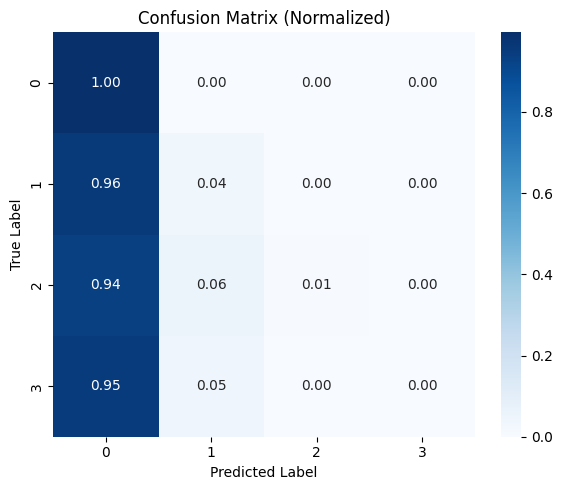

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# compute confusion matrix
cm = confusion_matrix(all_test_labels, all_test_preds)

# normalize to get percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[0, 1, 2, 3],  # replace with your actual class names if available
    yticklabels=[0, 1, 2, 3]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()


Class 0: 189748 samples (79.87%)
Class 1: 33457 samples (14.08%)
Class 2: 11237 samples (4.73%)
Class 3: 3128 samples (1.32%)


/tmp/ipython-input-3070363080.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=counts, palette="Blues_d")


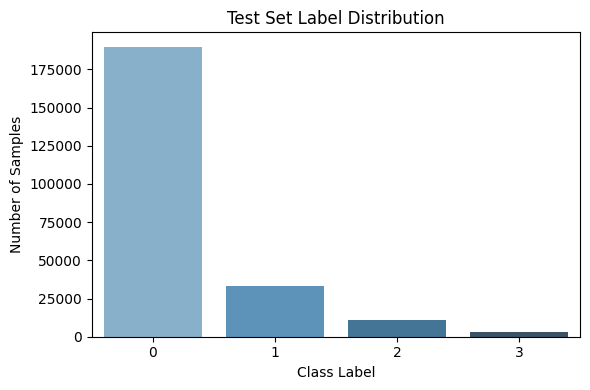

In [ ]:


# convert to numpy array if not already
all_test_labels = np.array(all_test_labels)

# count occurrences of each class
unique_labels, counts = np.unique(all_test_labels, return_counts=True)

# print counts
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} samples ({count / len(all_test_labels) * 100:.2f}%)")

# plot distribution
plt.figure(figsize=(6,4))
sns.barplot(x=unique_labels, y=counts, palette="Blues_d")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Test Set Label Distribution")
plt.tight_layout()
plt.show()


Predicted Class 0: 234567 samples (98.74%)
Predicted Class 1: 2890 samples (1.22%)
Predicted Class 2: 109 samples (0.05%)
Predicted Class 3: 4 samples (0.00%)


/tmp/ipython-input-111132145.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_preds, y=pred_counts, palette="Oranges_d")


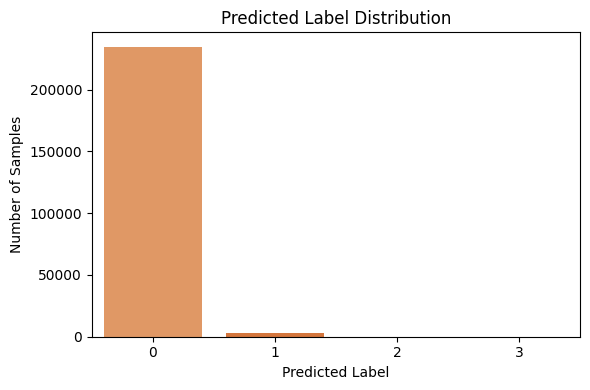

In [ ]:
# convert to numpy array
all_test_preds = np.array(all_test_preds)

# count occurrences of each predicted class
unique_preds, pred_counts = np.unique(all_test_preds, return_counts=True)

# print counts
for label, count in zip(unique_preds, pred_counts):
    print(f"Predicted Class {label}: {count} samples ({count / len(all_test_preds) * 100:.2f}%)")

# plot
plt.figure(figsize=(6,4))
sns.barplot(x=unique_preds, y=pred_counts, palette="Oranges_d")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Samples")
plt.title("Predicted Label Distribution")
plt.tight_layout()
plt.show()


**Observations**
- The model achieves high accuracy (~80%), but this is misleading because the majority of predictions are for class 0.

- The macro F1 score is very low (0.2441), indicating poor performance on minority classes (1–3).

- This confirms the strong class imbalance in our dataset, with ~80% of interactions being class 0.

**Next step**
To address this imbalance, we will experiment with:

- Weighted Cross-Entropy Loss

We will assign higher weights to minority classes to penalize misclassification more strongly.

- Ordinal Classification

This models the ordered nature of interaction labels, instead of treating them as purely categorical. This might help the model better capture the structure of high-level interactions without distorting user history distributions.



**Oversampling?**

**Oversampling of minority observations** were also considered, but we ultimately decided against it, as we felt that oversampling works best when:
1. Samples are independent.
2. Duplicating minority samples does not break the structure of the data.

In our case, however, each sample is a user + candidate pair, but users have **sequences of interactions**.

Duplicating rows for minority labels could:
- Create artificial bias, as the same user history appears multiple times.
- Teach the model that certain user histories are “more important,” inflating their influence.
- Lead to overfitting on repeated sequences.
- Distort the natural distribution of high-level interactions, which is meaningful in modeling user behavior.


### With weighted criterion

We shall now train the model again following the exact same steps as above, but now use weighted Cross-Entropy loss instead

**Reinitialise the model**

In [ ]:
model = SequentialHybridNCF(
    num_items=len(wid2idx),
    num_types=len(type2idx),
    num_time_bins=len(bins),
    num_wid=candidate_encodings["num_wid"],
    num_brand=candidate_encodings["num_brand"],
    num_shop=candidate_encodings["num_shop"],
    num_c1=candidate_encodings["num_c1"],
    num_c2=candidate_encodings["num_c2"],
    num_c3=candidate_encodings["num_c3"],
    num_c4=candidate_encodings["num_c4"],
    brand_lookup=candidate_encodings["brand_lookup"],
    shop_lookup=candidate_encodings["shop_lookup"],
    c1_lookup=candidate_encodings["c1_lookup"],
    c2_lookup=candidate_encodings["c2_lookup"],
    c3_lookup=candidate_encodings["c3_lookup"],
    c4_lookup=candidate_encodings["c4_lookup"],
    num_meta_features=len(meta_cols),
    emb_dim=64,
    hidden_dim=128,
    num_classes=4
).to(device)


**Reinitialise optimiser and scheduler**

In [ ]:
# reinitalise adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# reduce LR on plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

**Define our new weighted cross-entropy loss criterion**

In [ ]:
# CrossEntropyLoss with weighted loss ignores padding labels (-1)

# compute class frequencies
class_counts = train_df['label'].value_counts().sort_index().values
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum()  # normalize
class_weights = class_weights.to(device)

# do weighted loss to penalise misclassifying minority classes
criterion = nn.CrossEntropyLoss(weight=class_weights)

**Training loop**

In [ ]:
# TRAINING LOOP
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

num_epochs = 10
best_val_loss = float('inf')
model_path = '/content/drive/MyDrive/BT4222 Group 3/2. Models/lstm_ncf/best_lstm_ncf.pt'

for epoch in range(num_epochs):
    print("\n" + "="*50)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("="*50)


    # TRAIN
    model.train()
    total_train_loss = 0
    all_train_preds = []
    all_train_labels = []

    for batch in tqdm(train_loader, desc="Training"):
        # Move batch to device
        wid_seq = batch['wid_seq'].to(device)
        type_seq = batch['type_seq'].to(device)
        time_seq = batch['time_seq'].to(device)
        lengths = batch['lengths'].to(device)
        candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
        meta_features = batch['meta_features'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        logits = model(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)

        # mask padding candidates
        mask = labels != -1
        logits_flat = logits[mask]
        labels_flat = labels[mask]

        # compute loss
        loss = criterion(logits_flat, labels_flat)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()

        # predictions
        preds = torch.argmax(logits_flat, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels_flat.cpu().numpy())

    train_loss = total_train_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")


    # VALIDATE

    model.eval()
    total_val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            wid_seq = batch['wid_seq'].to(device)
            type_seq = batch['type_seq'].to(device)
            time_seq = batch['time_seq'].to(device)
            lengths = batch['lengths'].to(device)
            candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
            meta_features = batch['meta_features'].to(device)
            labels = batch['labels'].to(device)

            logits = model(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)

            mask = labels != -1
            logits_flat = logits[mask]
            labels_flat = labels[mask]

            loss = criterion(logits_flat, labels_flat)
            total_val_loss += loss.item()

            preds = torch.argmax(logits_flat, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels_flat.cpu().numpy())

    val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='macro', zero_division=0)

    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")

    # SCHEDULER
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning rate: {current_lr:.6f}")

    # SAVE BEST MODEL
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }, model_path)
        print("✅ Saved best model")

print("\n🎉 Training complete!")



Epoch 1/10


Training: 100%|██████████| 3757/3757 [02:19<00:00, 26.99it/s]


Train Loss: 1.3076, Train Acc: 0.4841


Validating: 100%|██████████| 805/805 [00:18<00:00, 43.67it/s]


Val Loss: 1.2748, Val Acc: 0.5121
Val Precision: 0.3168, Recall: 0.4275, F1: 0.2823
Learning rate: 0.001000
✅ Saved best model

Epoch 2/10


Training: 100%|██████████| 3757/3757 [02:18<00:00, 27.07it/s]


Train Loss: 1.2787, Train Acc: 0.5041


Validating: 100%|██████████| 805/805 [00:19<00:00, 41.35it/s]


Val Loss: 1.2708, Val Acc: 0.5250
Val Precision: 0.3189, Recall: 0.4295, F1: 0.2959
Learning rate: 0.001000
✅ Saved best model

Epoch 3/10


Training: 100%|██████████| 3757/3757 [02:21<00:00, 26.50it/s]


Train Loss: 1.2679, Train Acc: 0.5109


Validating: 100%|██████████| 805/805 [00:18<00:00, 42.66it/s]


Val Loss: 1.2687, Val Acc: 0.5123
Val Precision: 0.3184, Recall: 0.4282, F1: 0.2893
Learning rate: 0.001000
✅ Saved best model

Epoch 4/10


Training: 100%|██████████| 3757/3757 [02:17<00:00, 27.24it/s]


Train Loss: 1.2523, Train Acc: 0.5156


Validating: 100%|██████████| 805/805 [00:18<00:00, 42.87it/s]


Val Loss: 1.2721, Val Acc: 0.5208
Val Precision: 0.3176, Recall: 0.4254, F1: 0.2919
Learning rate: 0.001000

Epoch 5/10


Training: 100%|██████████| 3757/3757 [02:19<00:00, 26.91it/s]


Train Loss: 1.2327, Train Acc: 0.5189


Validating: 100%|██████████| 805/805 [00:18<00:00, 43.04it/s]


Val Loss: 1.2704, Val Acc: 0.5218
Val Precision: 0.3185, Recall: 0.4255, F1: 0.2917
Learning rate: 0.001000

Epoch 6/10


Training: 100%|██████████| 3757/3757 [02:22<00:00, 26.43it/s]


Train Loss: 1.2036, Train Acc: 0.5237


Validating: 100%|██████████| 805/805 [00:18<00:00, 43.22it/s]


Val Loss: 1.2827, Val Acc: 0.5289
Val Precision: 0.3189, Recall: 0.4188, F1: 0.2997
Learning rate: 0.000500

Epoch 7/10


Training: 100%|██████████| 3757/3757 [02:19<00:00, 26.86it/s]


Train Loss: 1.1215, Train Acc: 0.5386


Validating: 100%|██████████| 805/805 [00:19<00:00, 40.64it/s]


Val Loss: 1.3484, Val Acc: 0.5261
Val Precision: 0.3161, Recall: 0.4081, F1: 0.2965
Learning rate: 0.000500

Epoch 8/10


Training: 100%|██████████| 3757/3757 [02:17<00:00, 27.27it/s]


Train Loss: 1.0742, Train Acc: 0.5456


Validating: 100%|██████████| 805/805 [00:19<00:00, 41.67it/s]


Val Loss: 1.4008, Val Acc: 0.5327
Val Precision: 0.3149, Recall: 0.4004, F1: 0.2996
Learning rate: 0.000500

Epoch 9/10


Training: 100%|██████████| 3757/3757 [02:19<00:00, 26.92it/s]


Train Loss: 1.0375, Train Acc: 0.5513


Validating: 100%|██████████| 805/805 [00:18<00:00, 42.57it/s]


Val Loss: 1.4404, Val Acc: 0.5363
Val Precision: 0.3152, Recall: 0.3954, F1: 0.3029
Learning rate: 0.000250

Epoch 10/10


Training: 100%|██████████| 3757/3757 [02:20<00:00, 26.81it/s]


Train Loss: 0.9482, Train Acc: 0.5708


Validating: 100%|██████████| 805/805 [00:19<00:00, 41.52it/s]


Val Loss: 1.6925, Val Acc: 0.5416
Val Precision: 0.3122, Recall: 0.3797, F1: 0.3018
Learning rate: 0.000250

🎉 Training complete!


**Evaluation on test set**

In [ ]:
# 1. LOAD BEST MODEL

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\n✅ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best Val Loss: {checkpoint['val_loss']:.4f}, Best Val Acc: {checkpoint['val_acc']:.4f}")

# 2. TEST SET EVALUATION

model.eval()
all_test_preds = []
all_test_labels = []
all_test_probs = []
total_test_loss = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        wid_seq = batch['wid_seq'].to(device)
        type_seq = batch['type_seq'].to(device)
        time_seq = batch['time_seq'].to(device)
        lengths = batch['lengths'].to(device)
        candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
        meta_features = batch['meta_features'].to(device)
        labels = batch['labels'].to(device)

        # forward
        logits = model(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)

        # mask padding candidates
        mask = labels != -1
        logits_flat = logits[mask]
        labels_flat = labels[mask]

        # compute loss
        loss = criterion(logits_flat, labels_flat)
        total_test_loss += loss.item()

        # predictions
        probs = torch.softmax(logits_flat, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels_flat.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

# compute metrics
test_loss = total_test_loss / len(test_loader)
test_acc = accuracy_score(all_test_labels, all_test_preds)
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    all_test_labels, all_test_preds, average='macro', zero_division=0
)

print("\n" + "="*50)
print("TEST SET METRICS")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")



✅ Loaded best model from epoch 3
Best Val Loss: 1.2687, Best Val Acc: 0.5123


Testing: 100%|██████████| 805/805 [00:18<00:00, 42.57it/s]



TEST SET METRICS
Test Loss: 1.2631
Test Accuracy: 0.5117
Test Precision: 0.3188
Test Recall: 0.4305
Test F1 Score: 0.2890


**Confusion matrix**

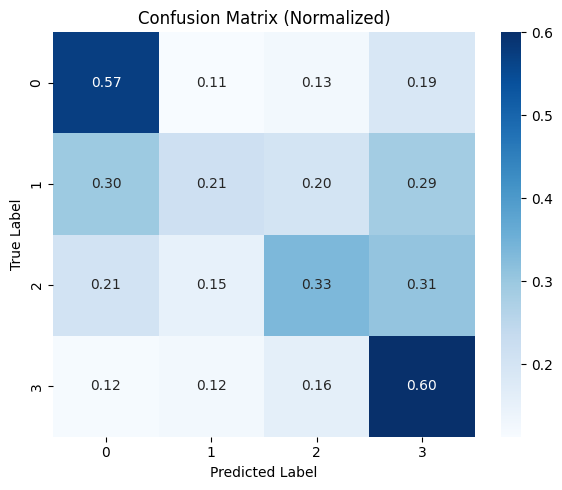

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# compute confusion matrix
cm = confusion_matrix(all_test_labels, all_test_preds)

# normalize to get percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[0, 1, 2, 3],  # replace with your actual class names if available
    yticklabels=[0, 1, 2, 3]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()


**Plot distribution of test labels**

Class 0: 189748 samples (79.87%)
Class 1: 33457 samples (14.08%)
Class 2: 11237 samples (4.73%)
Class 3: 3128 samples (1.32%)


/tmp/ipython-input-3070363080.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_labels, y=counts, palette="Blues_d")


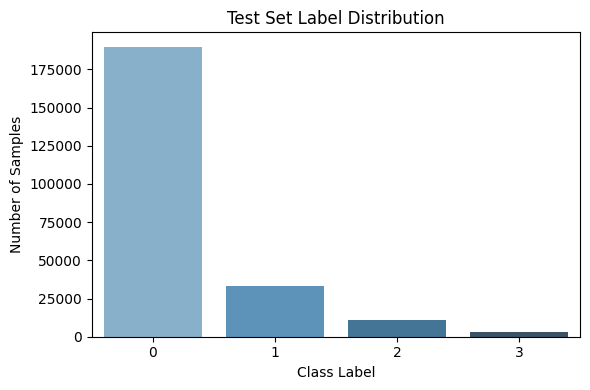

In [ ]:

# Convert to numpy array if not already
all_test_labels = np.array(all_test_labels)

# Count occurrences of each class
unique_labels, counts = np.unique(all_test_labels, return_counts=True)

# Print counts
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} samples ({count / len(all_test_labels) * 100:.2f}%)")

# Optional: plot distribution
plt.figure(figsize=(6,4))
sns.barplot(x=unique_labels, y=counts, palette="Blues_d")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Test Set Label Distribution")
plt.tight_layout()
plt.show()


**Plot distribution of predicted labels**

Predicted Class 0: 121375 samples (51.09%)
Predicted Class 1: 30625 samples (12.89%)
Predicted Class 2: 34778 samples (14.64%)
Predicted Class 3: 50792 samples (21.38%)


/tmp/ipython-input-1328007102.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_preds, y=pred_counts, palette="Oranges_d")


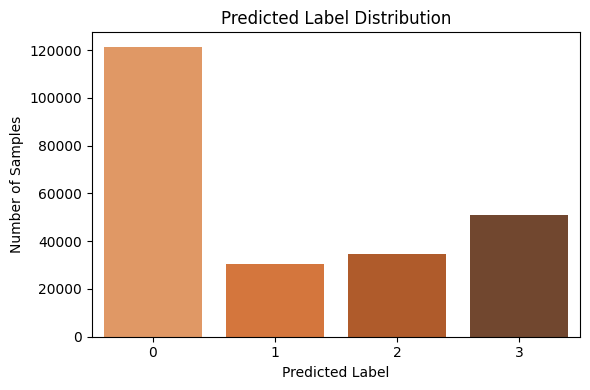

In [ ]:
# convert to numpy array
all_test_preds = np.array(all_test_preds)

# count occurrences of each predicted class
unique_preds, pred_counts = np.unique(all_test_preds, return_counts=True)

# print counts
for label, count in zip(unique_preds, pred_counts):
    print(f"Predicted Class {label}: {count} samples ({count / len(all_test_preds) * 100:.2f}%)")

# plot distribution
plt.figure(figsize=(6,4))
sns.barplot(x=unique_preds, y=pred_counts, palette="Oranges_d")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Samples")
plt.title("Predicted Label Distribution")
plt.tight_layout()
plt.show()


With weighted Cross-Entropy:
- The model now predicts higher classes more frequently, reflecting the true distribution of interactions.
- The model gives more attention to minority classes, reducing the bias toward class 0.

Overall, this helps the model better capture meaningful high-level interactions, which are critical for user behavior modeling.

#### Recommendation model-style evaluation metrics

helper functions to calculate the metrics

In [ ]:
import numpy as np

def hit_rate_at_k(user_preds, user_labels, K=10):
    """
    user_preds: list of predicted scores/labels for a single user
    user_labels: list of ground-truth labels for the same user
    Returns 1 if at least one positive item in top-K, else 0
    """
    # Sort candidates by predicted label descending
    topk_indices = np.argsort(user_preds)[::-1][:K]
    topk_labels = np.array(user_labels)[topk_indices]

    # Consider label > 0 as positive
    return int((topk_labels > 0).any())


In [ ]:
def ndcg_at_k(user_preds, user_labels, K=10):
    """
    user_preds: list of predicted scores/labels for a single user
    user_labels: list of ground-truth labels for the same user
    """
    topk_indices = np.argsort(user_preds)[::-1][:K]
    topk_labels = np.array(user_labels)[topk_indices]

    # DCG: sum((2^rel - 1)/log2(rank+1))
    dcg = np.sum((2**topk_labels - 1) / np.log2(np.arange(1, len(topk_labels)+1) + 1))

    # IDCG: ideal DCG for sorted ground-truth labels
    ideal_labels = np.sort(user_labels)[::-1][:K]
    idcg = np.sum((2**ideal_labels - 1) / np.log2(np.arange(1, len(ideal_labels)+1) + 1))

    return dcg / idcg if idcg > 0 else 0.0


To determine the k, we shall find check the distribution of `candidate_wid_list` first

Candidate list length stats:
count    173831.000000
mean          9.173007
std           8.573508
min           0.000000
25%           5.000000
50%           5.000000
75%          10.000000
max         200.000000
Name: num_candidates, dtype: float64

Value counts:
num_candidates
0      2103
1       464
2       445
3       436
4       414
       ... 
170       2
175       1
180       2
195       1
200       4
Name: count, Length: 83, dtype: int64


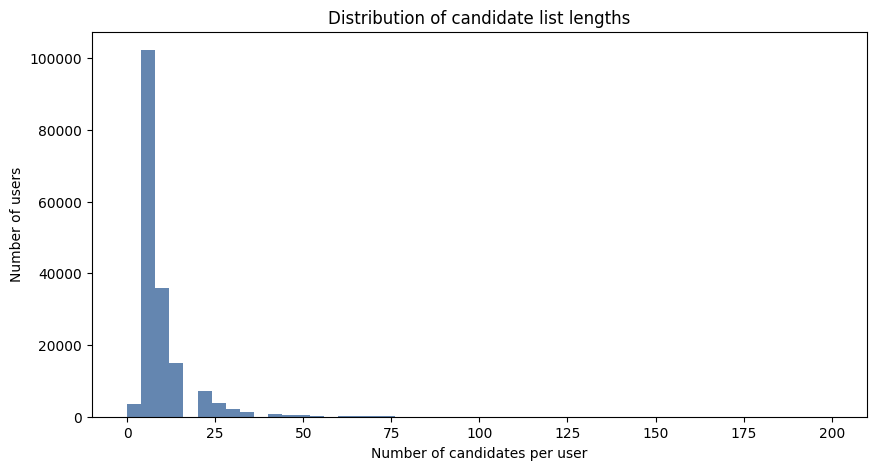

In [ ]:
# Compute candidate list lengths
queries_df['num_candidates'] = queries_df['candidate_label_list_int'].apply(len)

# Quick statistics
print("Candidate list length stats:")
print(queries_df['num_candidates'].describe())

# Value counts
print("\nValue counts:")
print(queries_df['num_candidates'].value_counts().sort_index())

# Plot distribution
plt.figure(figsize=(10,5))
plt.hist(queries_df['num_candidates'], bins=50, color='#23538F', alpha=0.7)
plt.xlabel("Number of candidates per user")
plt.ylabel("Number of users")
plt.title("Distribution of candidate list lengths")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

K = 5  # top-K candidates
all_hr = []
all_ndcg = []

all_test_preds = []
all_test_labels = []

model.eval()
total_test_loss = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        wid_seq = batch['wid_seq'].to(device)
        type_seq = batch['type_seq'].to(device)
        time_seq = batch['time_seq'].to(device)
        lengths = batch['lengths'].to(device)
        candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
        meta_features = batch['meta_features'].to(device)
        labels = batch['labels'].to(device)
        user_ids = batch['user_id']

        # Forward pass
        logits = model(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)
        loss = criterion(logits[labels != -1], labels[labels != -1])
        total_test_loss += loss.item()

        probs = torch.softmax(logits, dim=2)  # [B, C, num_classes]
        pred_classes = torch.argmax(probs, dim=2)  # [B, C]

        # Flattened metrics for overall accuracy, F1
        mask = labels != -1
        all_test_preds.extend(pred_classes[mask].cpu().numpy())
        all_test_labels.extend(labels[mask].cpu().numpy())

        # User-level metrics for HR@K and NDCG@K
        for u in range(len(user_ids)):
            user_label = labels[u].cpu().numpy()
            user_probs = probs[u].max(dim=1).values.cpu().numpy()  # max prob per candidate

            # Mask out padding candidates
            valid_mask = user_label >= 0
            if valid_mask.sum() == 0:
                continue

            user_label_valid = user_label[valid_mask]
            user_probs_valid = user_probs[valid_mask]

            # Rank candidates by predicted score
            ranked_idx = np.argsort(-user_probs_valid)
            top_k = ranked_idx[:min(K, len(ranked_idx))]
            top_k_labels = user_label_valid[top_k]

            # Hit Rate@K
            hit = int((top_k_labels > 0).any())
            all_hr.append(hit)

            # NDCG@K
            gains = 2**top_k_labels - 1
            discounts = np.log2(np.arange(2, len(top_k_labels)+2))
            dcg = np.sum(gains / discounts)

            # Ideal DCG
            ideal_labels = np.sort(user_label_valid)[::-1][:len(top_k_labels)]
            ideal_gains = 2**ideal_labels - 1
            idcg = np.sum(ideal_gains / discounts) if np.sum(ideal_gains) > 0 else 1.0

            ndcg = dcg / idcg
            all_ndcg.append(ndcg)

# Compute averages
test_loss = total_test_loss / len(test_loader)
test_acc = accuracy_score(all_test_labels, all_test_preds)
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    all_test_labels, all_test_preds, average='macro', zero_division=0
)
hr_at_k = np.mean(all_hr)
ndcg_at_k = np.mean(all_ndcg)

print("\n" + "="*50)
print("TEST SET METRICS")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Hit Rate@{K}: {hr_at_k:.4f}")
print(f"NDCG@{K}: {ndcg_at_k:.4f}")


Testing: 100%|██████████| 805/805 [00:19<00:00, 41.42it/s]



TEST SET METRICS
Test Loss: 1.2631
Test Accuracy: 0.5117
Test Precision: 0.3188
Test Recall: 0.4305
Test F1 Score: 0.2890
Hit Rate@10: 0.9782
NDCG@10: 0.5684


## Approach 2: Ordinal classification (treats the different classes in an ordinal manner)

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class SequentialHybridNCFOrdinal(nn.Module):
    def __init__(self, num_items, num_types, num_time_bins,
                 num_wid, num_brand, num_shop, num_c1, num_c2, num_c3, num_c4,
                 brand_lookup, shop_lookup, c1_lookup, c2_lookup, c3_lookup, c4_lookup,
                 num_meta_features, emb_dim=64, hidden_dim=128, num_thresholds=3):
        super().__init__()

        # ---- User history encoder ----
        self.item_emb = nn.Embedding(num_items+1, emb_dim, padding_idx=0)
        self.type_emb = nn.Embedding(num_types+1, emb_dim, padding_idx=0)
        self.time_emb = nn.Embedding(num_time_bins+1, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=emb_dim,
                    batch_first=True, dropout=0.3, num_layers=2)

        self.attention = Attention(emb_dim)
        self.empty_user_emb = nn.Parameter(torch.zeros(1, emb_dim))

        # ---- Candidate encoder (unchanged) ----
        self.candidate_encoder = CandidateEncoder(
            num_wid, num_brand, num_shop, num_c1, num_c2, num_c3, num_c4,
            brand_lookup, shop_lookup, c1_lookup, c2_lookup, c3_lookup, c4_lookup,
            emb_dim
        )

        # ---- Meta features ----
        self.meta_linear = nn.Linear(num_meta_features, emb_dim)

        # ---- Fusion + MLP for ordinal thresholds ----
        fusion_dim = emb_dim * 3
        self.mlp = nn.Sequential(
            nn.Linear(fusion_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_thresholds)  # logits for thresholds
        )

    def encode_user_history(self, wid_seq, type_seq, time_seq, lengths):
        mask = (wid_seq != 0)
        x = self.item_emb(wid_seq) + self.type_emb(type_seq) + self.time_emb(time_seq)

        batch_emb = self.empty_user_emb.repeat(x.size(0), 1)
        non_empty_mask = lengths > 0
        if non_empty_mask.any():
            x_non_empty = x[non_empty_mask]
            lengths_non_empty = lengths[non_empty_mask]
            mask_non_empty = mask[non_empty_mask]

            packed = pack_padded_sequence(x_non_empty, lengths_non_empty.cpu(),
                                          batch_first=True, enforce_sorted=False)
            packed_out, _ = self.lstm(packed)
            out, _ = pad_packed_sequence(packed_out, batch_first=True)

            user_emb_non_empty = self.attention(out, mask_non_empty)
            batch_emb[non_empty_mask] = user_emb_non_empty

        return batch_emb

    def forward(self, wid_seq, type_seq, time_seq, lengths,
                candidate_wid_idxs, meta_features):
        batch_size, num_candidates = candidate_wid_idxs.shape

        # Encode user
        user_emb = self.encode_user_history(wid_seq, type_seq, time_seq, lengths)

        # Encode candidates
        candidate_emb = self.candidate_encoder(candidate_wid_idxs)

        # Encode meta features
        meta_emb = self.meta_linear(meta_features)

        # Expand to match candidate dimension
        user_emb_exp = user_emb.unsqueeze(1).expand(-1, num_candidates, -1)
        meta_emb_exp = meta_emb.unsqueeze(1).expand(-1, num_candidates, -1)

        # Fusion
        fusion = torch.cat([user_emb_exp, candidate_emb, meta_emb_exp], dim=-1)
        fusion_flat = fusion.reshape(-1, fusion.size(-1))

        # Threshold logits → will apply sigmoid in loss
        threshold_logits_flat = self.mlp(fusion_flat)
        threshold_logits = threshold_logits_flat.reshape(batch_size, num_candidates, -1)

        return threshold_logits  # [batch, num_candidates, num_thresholds]


In [ ]:
def labels_to_thresholds(labels, num_thresholds=3):
    """
    Convert integer labels (0..num_thresholds) into cumulative thresholds.
    Example: label=2, thresholds=[1,1,0] for num_thresholds=3 (y>=1, y>=2, y>=3)
    """
    labels = labels.unsqueeze(-1)  # [B, C, 1] if batch per candidate
    thresholds = torch.arange(1, num_thresholds+1, device=labels.device).unsqueeze(0)  # [1, num_thresholds]
    thresholds = (labels >= thresholds).float()  # 1 if label >= threshold
    return thresholds  # [B, C, num_thresholds]


instantiate model

In [ ]:
# Number of thresholds = number of ordinal levels - 1
num_thresholds = 3  # for labels 0,1,2,3 → thresholds for y≥1, y≥2, y≥3

ordinal_model = SequentialHybridNCFOrdinal(
    num_items=len(wid2idx),
    num_types=len(type2idx),
    num_time_bins=len(bins),
    num_wid=candidate_encodings["num_wid"],
    num_brand=candidate_encodings["num_brand"],
    num_shop=candidate_encodings["num_shop"],
    num_c1=candidate_encodings["num_c1"],
    num_c2=candidate_encodings["num_c2"],
    num_c3=candidate_encodings["num_c3"],
    num_c4=candidate_encodings["num_c4"],
    brand_lookup=candidate_encodings["brand_lookup"],
    shop_lookup=candidate_encodings["shop_lookup"],
    c1_lookup=candidate_encodings["c1_lookup"],
    c2_lookup=candidate_encodings["c2_lookup"],
    c3_lookup=candidate_encodings["c3_lookup"],
    c4_lookup=candidate_encodings["c4_lookup"],
    num_meta_features=len(meta_cols),
    emb_dim=64,
    hidden_dim=128,
    num_thresholds=num_thresholds
).to(device)


In [ ]:
# example using pandas (much faster than looping PyTorch tensors)
thresholds = [1, 2, 3]
pos_weights = []

for t in thresholds:
    num_pos = (train_df['label'] >= t).sum()
    num_neg = (train_df['label'] < t).sum()
    weight = num_neg / num_pos if num_pos > 0 else 1.0
    pos_weights.append(weight)

pos_weights = torch.tensor(pos_weights, dtype=torch.float, device=device)
print("Per-threshold pos_weights:", pos_weights)


Per-threshold pos_weights: tensor([ 3.9692, 15.5209, 75.9367], device='cuda:0')


In [ ]:
import torch.nn.functional as F

import torch.nn.functional as F

def ordinal_bce_loss(logits, labels, pos_weight=None):
    """
    logits: [B, C, num_thresholds]
    labels: [B, C] with class labels 0..num_thresholds
    pos_weight: tensor[num_thresholds] for weighting positive examples per threshold
    """
    num_thresholds = logits.size(-1)
    target = torch.zeros_like(logits)
    for k in range(num_thresholds):
        target[..., k] = (labels >= (k+1)).float()

    # Compute BCE with per-threshold pos_weight
    loss = F.binary_cross_entropy_with_logits(logits, target, pos_weight=pos_weight)
    return loss


def train_epoch_ordinal(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc="Training"):
        wid_seq = batch['wid_seq'].to(device)
        type_seq = batch['type_seq'].to(device)
        time_seq = batch['time_seq'].to(device)
        lengths = batch['lengths'].to(device)
        candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
        meta_features = batch['meta_features'].to(device)
        labels = batch['labels'].to(device)

        logits = ordinal_model(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)

        # mask padded candidates
        mask = labels != -1
        logits_flat = logits[mask]
        labels_flat = labels[mask]

        # compute weighted ordinal BCE loss
        loss = ordinal_bce_loss(logits_flat, labels_flat, pos_weight=pos_weights)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(ordinal_model.parameters(), max_norm=1.0)
        optimizer.step()


        total_loss += loss.item()

        # Compute predicted class from thresholds
        probs = torch.sigmoid(logits_flat)
        pred_classes = probs.sum(dim=-1).long()  # cumulative threshold sum → predicted class
        all_preds.extend(pred_classes.cpu().numpy())
        all_labels.extend(labels_flat.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    return avg_loss, accuracy


In [ ]:
def evaluate_ordinal(model, loader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            wid_seq = batch['wid_seq'].to(device)
            type_seq = batch['type_seq'].to(device)
            time_seq = batch['time_seq'].to(device)
            lengths = batch['lengths'].to(device)
            candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
            meta_features = batch['meta_features'].to(device)
            labels = batch['labels'].to(device)

            logits = model(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)

            mask = labels != -1
            logits_flat = logits[mask]
            labels_flat = labels[mask]

            loss = ordinal_bce_loss(logits_flat, labels_flat)
            total_loss += loss.item()

            probs = torch.sigmoid(logits_flat)
            pred_classes = probs.sum(dim=-1).long()  # predicted class from thresholds
            all_preds.extend(pred_classes.cpu().numpy())
            all_labels.extend(labels_flat.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    return avg_loss, accuracy, all_labels, all_preds


In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch

# ========================================
# Training loop for ordinal regression
# ========================================

num_epochs = 10
best_val_loss = float('inf')
model_path = '/content/drive/MyDrive/BT4222 Group 3/2. Models/lstm_ordinal/best_lstm_ordinal_model.pt'

for epoch in range(num_epochs):
    print("\n" + "="*50)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("="*50)

    # ----------------------
    # Train
    # ----------------------
    ordinal_model.train()
    total_train_loss = 0
    all_train_preds = []
    all_train_labels = []

    for batch in tqdm(train_loader, desc="Training"):
        wid_seq = batch['wid_seq'].to(device)
        type_seq = batch['type_seq'].to(device)
        time_seq = batch['time_seq'].to(device)
        lengths = batch['lengths'].to(device)
        candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
        meta_features = batch['meta_features'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        logits = ordinal_model(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)

        # Mask out padded candidates
        mask = labels != -1
        logits_flat = logits[mask]
        labels_flat = labels[mask]

        # Compute ordinal BCE loss
        loss = ordinal_bce_loss(logits_flat, labels_flat)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(ordinal_model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()

        # Predictions from thresholds
        probs = torch.sigmoid(logits_flat)
        preds = probs.sum(dim=-1).long()
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels_flat.cpu().numpy())

    train_loss = total_train_loss / len(train_loader)
    train_acc = (np.array(all_train_preds) == np.array(all_train_labels)).mean()
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # ----------------------
    # Validation
    # ----------------------
    val_loss, val_acc, val_labels, val_preds = evaluate_ordinal(ordinal_model, val_loader, device)

    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        val_labels, val_preds, average='macro', zero_division=0
    )
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")

    # ----------------------
    # Save best model
    # ----------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': ordinal_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }, model_path)
        print("✅ Saved best model")

print("\n🎉 Training complete!")



Epoch 1/10


Training: 100%|██████████| 3757/3757 [01:51<00:00, 33.57it/s]


Train Loss: 0.7898, Train Acc: 0.1968


Evaluating: 100%|██████████| 805/805 [00:19<00:00, 40.32it/s]


Val Loss: 0.7432, Val Acc: 0.1813
Val Precision: 0.2289, Recall: 0.2389, F1: 0.1004
✅ Saved best model

Epoch 2/10


Training: 100%|██████████| 3757/3757 [01:55<00:00, 32.65it/s]


Train Loss: 0.7895, Train Acc: 0.1975


Evaluating: 100%|██████████| 805/805 [00:19<00:00, 41.68it/s]


Val Loss: 0.7427, Val Acc: 0.1747
Val Precision: 0.2302, Recall: 0.2414, F1: 0.0952
✅ Saved best model

Epoch 3/10


Training: 100%|██████████| 3757/3757 [01:56<00:00, 32.34it/s]


Train Loss: 0.7905, Train Acc: 0.1969


Evaluating: 100%|██████████| 805/805 [00:19<00:00, 40.37it/s]


Val Loss: 0.7394, Val Acc: 0.1858
Val Precision: 0.2289, Recall: 0.2375, F1: 0.1035
✅ Saved best model

Epoch 4/10


Training: 100%|██████████| 3757/3757 [01:53<00:00, 32.97it/s]


Train Loss: 0.7906, Train Acc: 0.1970


Evaluating: 100%|██████████| 805/805 [00:19<00:00, 40.59it/s]


Val Loss: 0.7420, Val Acc: 0.1819
Val Precision: 0.2290, Recall: 0.2388, F1: 0.1012

Epoch 5/10


Training: 100%|██████████| 3757/3757 [01:52<00:00, 33.31it/s]


Train Loss: 0.7903, Train Acc: 0.1971


Evaluating: 100%|██████████| 805/805 [00:19<00:00, 41.04it/s]


Val Loss: 0.7405, Val Acc: 0.1781
Val Precision: 0.2297, Recall: 0.2401, F1: 0.0977

Epoch 6/10


Training: 100%|██████████| 3757/3757 [01:50<00:00, 33.92it/s]


Train Loss: 0.7899, Train Acc: 0.1974


Evaluating: 100%|██████████| 805/805 [00:19<00:00, 40.49it/s]


Val Loss: 0.7376, Val Acc: 0.1805
Val Precision: 0.2290, Recall: 0.2389, F1: 0.0994
✅ Saved best model

Epoch 7/10


Training: 100%|██████████| 3757/3757 [01:50<00:00, 34.13it/s]


Train Loss: 0.7904, Train Acc: 0.1973


Evaluating: 100%|██████████| 805/805 [00:19<00:00, 41.03it/s]


Val Loss: 0.7413, Val Acc: 0.1828
Val Precision: 0.2294, Recall: 0.2387, F1: 0.1017

Epoch 8/10


Training: 100%|██████████| 3757/3757 [01:53<00:00, 33.15it/s]


Train Loss: 0.7903, Train Acc: 0.1975


Evaluating: 100%|██████████| 805/805 [00:20<00:00, 40.10it/s]


Val Loss: 0.7396, Val Acc: 0.1843
Val Precision: 0.2293, Recall: 0.2382, F1: 0.1029

Epoch 9/10


Training: 100%|██████████| 3757/3757 [01:53<00:00, 33.07it/s]


Train Loss: 0.7903, Train Acc: 0.1975


Evaluating: 100%|██████████| 805/805 [00:19<00:00, 40.63it/s]


Val Loss: 0.7405, Val Acc: 0.1832
Val Precision: 0.2296, Recall: 0.2387, F1: 0.1017

Epoch 10/10


Training: 100%|██████████| 3757/3757 [01:56<00:00, 32.27it/s]


Train Loss: 0.7905, Train Acc: 0.1973


Evaluating: 100%|██████████| 805/805 [00:20<00:00, 39.42it/s]


Val Loss: 0.7375, Val Acc: 0.1839
Val Precision: 0.2292, Recall: 0.2381, F1: 0.1020
✅ Saved best model

🎉 Training complete!


In [ ]:
model_path = '/content/drive/MyDrive/BT4222 Group 3/2. Models/lstm_ordinal/best_lstm_ordinal_model.pt'
checkpoint = torch.load(model_path, map_location=device, weights_only=False)
ordinal_model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [ ]:
# test set evaluation

ordinal_model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        wid_seq = batch['wid_seq'].to(device)
        type_seq = batch['type_seq'].to(device)
        time_seq = batch['time_seq'].to(device)
        lengths = batch['lengths'].to(device)
        candidate_wid_idxs = batch['candidate_wid_idxs'].to(device)
        meta_features = batch['meta_features'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        logits = ordinal_model(wid_seq, type_seq, time_seq, lengths, candidate_wid_idxs, meta_features)

        # mask padded candidates
        mask = labels != -1
        logits_flat = logits[mask]
        labels_flat = labels[mask]

        # probabilities → ordinal predictions
        probs = torch.sigmoid(logits_flat)
        preds = probs.sum(dim=-1).long()

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels_flat.cpu().numpy())


test_acc = accuracy_score(all_test_labels, all_test_preds)
test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
    all_test_labels, all_test_preds, average='macro', zero_division=0
)

print("\n" + "="*50)
print("TEST SET METRICS")
print("="*50)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")



Testing: 100%|██████████| 805/805 [00:19<00:00, 41.40it/s]



TEST SET METRICS
Test Accuracy: 0.1825
Test Precision: 0.2270
Test Recall: 0.2369
Test F1 Score: 0.1009


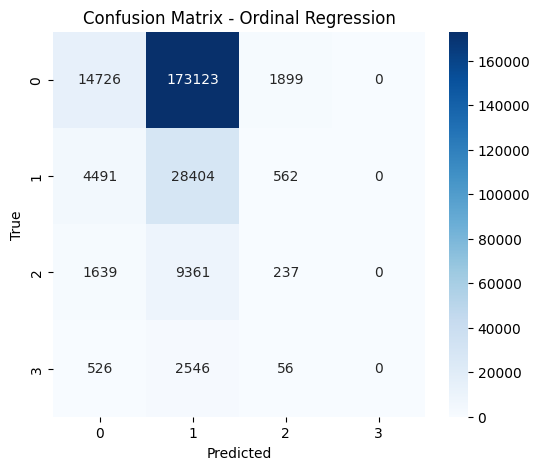

In [ ]:
# compute confusion matrix
cm = confusion_matrix(all_test_labels, all_test_preds, labels=[0,1,2,3])

# plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Ordinal Regression")
plt.show()


Predicted Class 0: 21382 samples (9.00%)
Predicted Class 1: 213434 samples (89.84%)
Predicted Class 2: 2754 samples (1.16%)


/tmp/ipython-input-1613975104.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_preds, y=pred_counts, palette="Oranges_d")


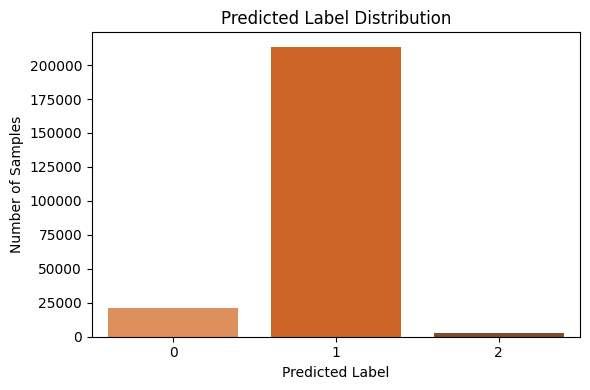

In [ ]:

# convert to numpy array
all_test_preds = np.array(all_test_preds)

# count occurrences of each predicted class
unique_preds, pred_counts = np.unique(all_test_preds, return_counts=True)

# print counts
for label, count in zip(unique_preds, pred_counts):
    print(f"Predicted Class {label}: {count} samples ({count / len(all_test_preds) * 100:.2f}%)")

# plot distribution
plt.figure(figsize=(6,4))
sns.barplot(x=unique_preds, y=pred_counts, palette="Oranges_d")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Samples")
plt.title("Predicted Label Distribution")
plt.tight_layout()
plt.show()


After switching to an ordinal classification loss, the model predictions show a strong shift toward the mid-range class (class 1)


**Observations:**
- The model now explicitly respects the ordinal nature of the labels, focusing predictions around the “central” interaction level (class 1).

- Extreme classes (0 and 2/3) are predicted less often, reflecting the model’s attempt to capture the ordering of interactions rather than treating them as independent categories.

- This demonstrates that ordinal loss can help the model learn relative differences between interaction levels, which is more aligned with the actual user behavior patterns.


This approach reduces the risk of overpredicting extreme classes, which was a challenge with standard (un-weighted) Cross-Entropy.

Future tuning could combine weighted ordinal loss to balance both class imbalance and ordinal relationships simultaneously.